In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin
from sklearn.datasets import make_regression

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMRegressor

from scipy.stats import entropy
from copy import deepcopy as copy

%matplotlib inline

In [16]:
import warnings
warnings.filterwarnings('ignore')

# Класс дискретизации по принципу деления по медиане

In [17]:
# https://www.theanalysisfactor.com/continuous-and-categorical-variables-the-trouble-with-median-splits/

In [18]:
class MedianBinarizer(TransformerMixin):
    def __init__(self, n_bins: int):
        self.n_bins = n_bins
        self.x_bins = None
        self.encoder = None
    
    def _get_feature_bins(self, X):
        #extra_bin = 0
        #if X.shape[0] % self.n_bins != 0:
        #    extra_bin = 1
        #    print('number of bins does not fit to dataset'
        #          ', extending number of bins to extra one')
        #
        #n_batch = X.shape[0] // self.n_bins
        #X_sorted = np.sort(X)
        #x_bins = [X[i*n_batch:(i+1)*n_batch] for i in range(self.n_bins + extra_bin)]
        
        iterations = np.log2(self.n_bins)
        if iterations - int(iterations) != 0:
            raise Exception('bins should be a power of 2')
        
        # получаем вариационный ряд
        x_bins = [np.sort(X)]
        for i in range(int(iterations)):
            new_bins = list()
            for j in x_bins:
                # середина среза вариационного ряда
                index = j.shape[0] // 2
                new_bins += [j[:index], j[index:]]
            x_bins = new_bins
        return x_bins
    
    def _lookup(self, x):
        for k, _bin in enumerate(self.x_bins):
            if x <= _bin[-1]:
                return k
        return k
    
    def _real_to_category(self, X):
        # X should not be a column vector
        X_new = []
        for x in X:
            i = self._lookup(x)
            
            if i != -1:
                X_new.append(i)
            else:
                raise Exception('something went wrong')

        return np.array(X_new).reshape(-1, 1)
    
    def fit(self, X):
        self.x_bins = self._get_feature_bins(X)
        X_cat = self._real_to_category(X)
        
        self.encoder = OneHotEncoder(sparse=False)
        self.encoder.fit(X_cat)
    
    def transform_categorical(self, X):
        return self._real_to_category(X)
    
    def transform_onehot(self, X):
        x_cat = self._real_to_category(X)
        return self.encoder.transform(x_cat)
    
    def onehot_to_categorical(self, X):
        return np.argwhere(X)[:, 1]
    
    def categorical_to_onehot(self, X):
        return self.encoder.transform(X)

In [19]:
def synchronize_counts(_from: dict, _to: dict):
    subset = np.setdiff1d(list(_from.keys()), list(_to.keys()))
    for i in subset:
        _to[i] = 0

In [20]:
def cross_entropy(p, q):
    p = np.array(p)
    q = np.array(q)
    q[q == 0] = 0.0001
    return -np.sum(p * np.log(q))

# Дискретизированные переменные имеют равномерное распределение

In [21]:
binarizer = MedianBinarizer(32)

In [22]:
rnd_vals = np.random.lognormal(size=1000)

In [23]:
binarizer.fit(rnd_vals)
result = binarizer.transform_categorical(rnd_vals)

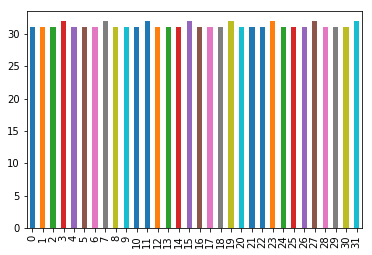

In [24]:
pd.Series(result.squeeze()).value_counts().sort_index().plot.bar()

In [25]:
X, y, coefs = make_regression(n_samples=2000, n_features=15, n_informative=4, n_targets=3, coef=True, random_state=42)
# introduce multicollinearity  (15, 16, 17 features)
X = np.concatenate([X, y], axis=1)

In [26]:
feature_space = []
binarizers = []
for i in range(X.shape[1]):
    feature = X[:, i].squeeze()
    binarizer = MedianBinarizer(32)
    binarizer.fit(feature)
    binarizers.append(binarizer)
    feature_space.append(
        {'category': binarizer.transform_categorical(feature),
        'onehot': binarizer.transform_onehot(feature)}
    )

In [27]:
test_classifiers = [
    LogisticRegression(random_state=42, multi_class='ovr'),
    LinearSVC(multi_class='ovr'),
    LGBMRegressor(boosting_type='rf')
]

In [51]:
np.random.seed(42)

global_stats = []
ix_subsets = []
for initial_feature in range(len(feature_space)):
    #initial_feature = 0# np.random.randint(0, len(feature_space))

    dataset_size = X.shape[0]
    # free_features is a list of observation indices
    free_features = [i for i in range(len(feature_space)) if i != initial_feature]
    # subset is a list of observations
    subset = [feature_space[initial_feature]['onehot']]
    # indices of the features in the subset
    subset_indices = [initial_feature]

    while len(subset) != len(feature_space):
        max_entropy = -1
        feature_index = -1
        new_feature = None

        local_stats = []


        for ix_feature, feature in enumerate(free_features):
            if len(subset) > 1:
                input_features = np.concatenate(subset, axis=1)
            else:
                input_features = subset[0]

            clr = copy(test_classifiers[0])
            #train model on the given subset and new feature
            clr.fit(input_features, feature_space[feature]['category'].squeeze())
            #predict that feature with the given subset
            predicted = clr.predict(input_features)

            predicted_onehot = binarizers[feature].categorical_to_onehot(predicted.reshape(-1, 1))
            pred_difference = (predicted_onehot != feature_space[feature]['onehot']).astype(np.int32) # 0110
            #pred_difference = ((predicted_onehot == 1) & (feature_space[feature]['onehot'] == 0)).astype(np.int32) # 0010

            pred_category, pred_counts = np.unique(predicted, return_counts=True)
            real_category, real_counts = np.unique(feature_space[feature]['category'], return_counts=True)

            pred_proba = pred_counts / dataset_size
            real_proba = real_counts / dataset_size

            real_stats = dict(zip(real_category, real_proba))
            pred_stats =  dict(zip(pred_category, pred_proba))

            synchronize_counts(real_stats, pred_stats)

            ce_r_r = cross_entropy(list(real_stats.values()), list(real_stats.values()))
            ce_p_p = cross_entropy(list(pred_stats.values()), list(pred_stats.values()))
            ce_r_p = cross_entropy(list(real_stats.values()), list(pred_stats.values()))

            if max_entropy < ce_r_p:
                max_entropy = ce_r_p
                feature_index = ix_feature
                new_feature = pred_difference

            local_stats.append({'rr': ce_r_r, 'pp': ce_p_p, 'rp': ce_r_p})
        #print('#'*100)
        #print('subset', subset)
        #print(pd.DataFrame(stats, index=free_features))
        #print('#'*100)
        
        subset.append(new_feature)
        subset_indices.append(free_features[feature_index])
        del free_features[feature_index]

    #print('generated ordered list of variables')
    global_stats.append(local_stats)
    ix_subsets.append(subset_indices)
    print(subset_indices)
print('real informative variables')
print(np.unique(np.argwhere(coefs > 0)).tolist() + [15, 16, 17])

[0, 13, 3, 16, 15, 17, 11, 10, 2, 6, 12, 9, 5, 4, 1, 7, 8, 14]
[1, 6, 9, 7, 8, 11, 16, 4, 17, 15, 12, 13, 3, 0, 10, 5, 14, 2]
[2, 10, 12, 17, 15, 5, 8, 9, 3, 1, 0, 6, 14, 7, 4, 13, 11, 16]
[3, 5, 17, 15, 16, 11, 7, 10, 6, 1, 8, 4, 9, 13, 0, 14, 2, 12]
[4, 16, 9, 3, 17, 2, 14, 7, 10, 12, 11, 5, 1, 13, 8, 6, 0, 15]
[5, 8, 11, 15, 16, 10, 7, 3, 9, 17, 2, 12, 4, 13, 0, 6, 1, 14]
[6, 11, 4, 16, 15, 9, 0, 17, 7, 3, 2, 14, 13, 1, 8, 10, 5, 12]
[7, 12, 4, 5, 9, 11, 13, 15, 10, 3, 16, 2, 17, 1, 14, 0, 8, 6]
[8, 16, 2, 12, 5, 10, 1, 14, 11, 6, 13, 7, 0, 3, 9, 17, 4, 15]
[9, 8, 17, 11, 2, 10, 16, 7, 13, 0, 3, 5, 6, 1, 4, 12, 14, 15]
[10, 15, 8, 12, 17, 5, 4, 0, 11, 6, 1, 7, 2, 13, 9, 3, 14, 16]
[11, 0, 3, 16, 5, 8, 17, 13, 10, 12, 14, 6, 9, 1, 4, 7, 2, 15]
[12, 8, 5, 3, 9, 0, 17, 14, 10, 15, 13, 6, 1, 11, 4, 2, 16, 7]
[13, 6, 15, 11, 17, 10, 8, 1, 4, 7, 3, 5, 14, 0, 2, 12, 9, 16]
[14, 11, 5, 16, 12, 1, 3, 4, 0, 7, 10, 13, 6, 17, 9, 2, 15, 8]
[15, 10, 7, 8, 11, 3, 0, 17, 9, 4, 6, 5, 13, 1, 2, 12, 

# Попытка отранжировать переменные по значимости

## (как часто кросс-энтропия была максимальной)

In [52]:
indices_scores = {k: 0 for k in range(0, 18)}

for i in ix_subsets:
    for s, j in enumerate(i[::-1][:-1]):
        indices_scores[j] += (s + 1)

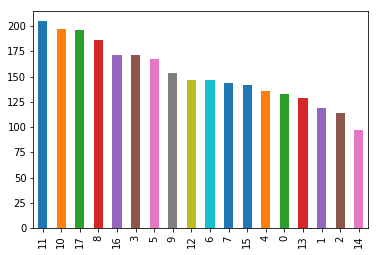

In [53]:
pd.Series(indices_scores).sort_values(ascending=False).plot(kind='bar')